In [54]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.02

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, xlim=[], ylim=[]):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = [[] for _ in range(len(scenes))]
        self.adding_lines = False
        self.added_lines = [[] for _ in range(len(scenes))]
        self.adding_rects = False
        self.added_rects = [[] for _ in range(len(scenes))]
        # DODANO: zapisz tytuł sceny
        self.scene_title = self.scenes[0].title if len(self.scenes) and self.scenes[0].title else ""
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.custom_axis = len(xlim) != 0 or len(ylim) != 0

    def set_axes(self, ax):
        self.ax = ax
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points[self.i].append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines[self.i].append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects[self.i].append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        return self.added_points[self.i]
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        return self.added_lines[self.i]
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        return self.added_rects[self.i]
  
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        return Scene(self.added_points[self.i], self.added_lines[self.i]+self.added_rects[self.i])


    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[self.i][-1].add_points([new_point])
            self.draw(autoscaling = False,hand_drawing=True)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[self.i][-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False,hand_drawing=True)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                self.rect_points.append(new_point)
                self.draw(autoscaling = False,hand_drawing=True)
            elif len(self.rect_points) > 1:
                # DODANO: zmiana metody wykrywania zakończenia figury.
                # Teraz punkt self.rect_points[0] jest środkiem okręgu o promieniu TOLERANCE*(mediana zakresów wykresu)
                # Gdy użytkownik kliknie w obrębie tego okręgu, figura zostanie zamknięta
                if (new_point[0] - self.rect_points[0][0]) ** 2 + (new_point[1] - self.rect_points[0][1]) ** 2 <= (np.mean([self.ax.get_xlim()[1] - self.ax.get_xlim()[0], self.ax.get_ylim()[1]-self.ax.get_ylim()[0]])*TOLERANCE) ** 2:
                    self.added_rects[self.i][-1].add((self.rect_points[-1], self.rect_points[0]))
                    self.new_rect()
                else:    
                    self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False, hand_drawing=True)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True, hand_drawing = False):
        # DODANO: ustawienie zakresów osi wykresu
        autoscale_axis='both'
        if not autoscaling:
            if self.custom_axis:
                xlim = self.xlim  
                ylim = self.ylim  

            choose_autoscale_axis = [False, False] # [OX, OY]

            if not self.custom_axis or not self.xlim:
                xlim = self.ax.get_xlim()
                choose_autoscale_axis[0] = True
            
            if not self.custom_axis or not self.ylim:
                ylim = self.ax.get_ylim()
                choose_autoscale_axis[1] = True

            if choose_autoscale_axis == [True, False]:
                autoscale_axis = 'x'
                autoscaling = not hand_drawing
            if choose_autoscale_axis == [False, True]:
                autoscale_axis = 'y'
                autoscaling = not hand_drawing

        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points[self.i]):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs, zorder=3)
        for collection in (self.scenes[self.i].lines + self.added_lines[self.i] + self.added_rects[self.i]):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(enable=autoscaling, axis=autoscale_axis)

        if autoscale_axis == 'y':
            self.ax.set_xlim(xlim)

        if autoscale_axis == 'x':
            self.ax.set_ylim(ylim)
      
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            
        # DODANO: tytuł sceny
        fig = plt.gcf() # Pobierz aktywne okno
        fig.suptitle(self.scene_title)
        
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [55]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], title=""):
        self.points=points
        self.lines=lines
        # ADDED: Scene title
        self.title = '\n'+title if title != "" else ""

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [], points = [], lines = [], json = None, title="", xlim=[], ylim=[]):
        # DODANO: tytuł wykresu
        self.plot_title = title
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.is_not_custom_axis = len(xlim)==0 and len(ylim)==0

        # NAPRAWIONO: pobieranie scen z wcześniej utworzonego wykresu
        if not scenes:
            self.scenes = [Scene()]
        else:
            self.scenes = scenes

        if json is None:
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]], title=scene["title"]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines],
                          "title": scene.title[1:]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            result = self.callback.get_added_points()
            return result
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            result = self.callback.get_added_lines()
            return result

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            result = self.callback.get_added_figure()
            return result

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            result = self.callback.get_added_elements()
            return result

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        # DODANO: tytuł wykresu
        fig = plt.figure(num=self.plot_title)
        # DODANO: ustawienie zakresów osi wykresu
        self.callback = _Button_callback(self.scenes, self.xlim, self.ylim)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        # DODANO: ustawienie zakresów osi wykresu
        self.callback.draw(self.is_not_custom_axis)

## Sprawdzanie monotoniczności wielokąta

In [56]:
def linesOfPolygon(plot):
    figures = []
    for figure in plot.get_added_figure():
        figures.append(figure.lines)
    return figures[0]

In [57]:
def findPoints(lines : list[tuple[tuple[float,float],tuple[float,float]]]) -> tuple[float,float, list[tuple[float,float]]]:
    points = []
    for i in range(len(lines)):
        points.append(lines[i][0])
    
    p = max(points, key=lambda x : (x[1],x[0]))
    q = min(points, key=lambda x : (x[1],x[0]))
    return p, q, points

def monotonePolygon(lines : list[tuple[tuple[float,float],tuple[float,float]]]) -> bool:
    p, q, points = findPoints(lines) # highest_point / lowest_point / list of points

    n = len(points) # number of points of polygon

    i = 0
    for j in range(n):
        if points[j] == p:
            break
        i += 1
        
    while points[i % n] != q:
        if points[i % n][1] < points[((i+1) % n)][1]:
            return False
        i += 1
    
    while points[i % n] != p:
        if points[i % n][1] > points[((i+1) % n)][1]:
            return False
        i += 1
    
    return True

## Klasyfikacja wierzchołków wielokąta

In [58]:
def orient(p,q,r,epsilon = 10e-12):
        return ((p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0]))

def distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def verticesOfPolygon(lines, epsilon = 10e-12):
    
    p, q, points = findPoints(lines) # highest_point / lowest_point / list of points

    scene = []

    started_point = [] # green
    final_point = [] # red
    merged_point = [] # purple
    divided_point = [] # cyan
    correct_point = [] # brown

    n = len(points)

    i = 0
    for j in range(n):
        if points[j] == p:
            break
        i += 1

    fst = points[i % n]
    snd = points[(i+1) % n]
    thd = points[(i+2) % n]

    started_point.append(p)
    
    
    while snd != p:
        det = orient(fst, thd, snd)
        #started_point
        if det < -epsilon and fst[1] < snd[1] and thd[1] < snd[1]:
            started_point.append(snd)
        # final_point
        elif det < -epsilon and snd[1] < fst[1] and snd[1] < thd[1]:
            final_point.append(snd)
        # merged_point
        elif det > epsilon and snd[1] < fst[1] and snd[1] < thd[1]:
            merged_point.append(snd)
        # divided_point
        elif det > epsilon and fst[1] < snd[1] and thd[1] < snd[1]:
            divided_point.append(snd)
        # correct point
        else:
            correct_point.append(snd)
        i += 1

        fst = snd
        snd = thd
        thd = points[(i+2) % n]
    # print(points)
    # print(started_point, final_point, merged_point, divided_point, correct_point, sep="\n")
    
    scene.append(Scene( [PointsCollection(points)], [LinesCollection(lines)]))
    scene.append(Scene([PointsCollection(started_point, color = 'green'),
              PointsCollection(final_point, color = 'red'), PointsCollection(merged_point, color = 'purple'),
              PointsCollection(divided_point, color = 'cyan'), PointsCollection(correct_point, color = 'brown')], [LinesCollection(lines)]))
    return scene

## Triangulacja wielokąta monotonicznego


In [59]:
def convertToLines(points): # function to convert given points to lines that are creating polygon
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def checkSameChains(left_chain, right_chain, a, b): # check if the points are in the same chains
    if (a in left_chain and b in left_chain) or (a in right_chain and b in right_chain):
        return True
    return False

def isTriangleOfPolygon(chain, a, b, c, epsilon = 10e-12): # true - if triangle is in polygon
    if b in chain:
        return orient(a, b, c) > epsilon 
    else:
        return orient(a, b, c) < -epsilon

def adjacentVertices(lines, a, b): # check if lines [a,b] is not in the circuit of plygon (we don't want to add line that is not in the triangulation)
    if (a,b) in lines: return False
    if (b,a) in lines: return False
    return True

 

def triangulateMonotonePolygon(P):
    p, q, points = findPoints(P)
    circuit = P.copy()
    left_chain = set()
    right_chain = set()
    scenes = []
    
    n = len(points)

    i = 0
    for j in range(n):
        if points[j] == p:
            break
        i += 1

    j = i
    while points[j % n] != q:
        left_chain.add(points[j % n])
        j -= 1

    j = i
    while points[(j+1) % n] != q:
        right_chain.add(points[(j+1) % n])
        j += 1
    right_chain.add(q)


    # scenes.append(Scene(points=[PointsCollection(points)],lines = [LinesCollection(convertToLines(list(right_chain))), 
    #                                                 LinesCollection(convertToLines(list(left_chain)))]))

    new_points = sorted(points,key=lambda x : (x[1], x[0]), reverse=True)
    
    # scenes.append(Scene(points = [PointsCollection(new_points)], lines = [LinesCollection(convertToLines(new_points), color = 'red')]))
    
    final_lines = []

    stack = [new_points[0], new_points[1]]

    for i in range(2, len(new_points)):
        curr_stack = stack.copy()
        curr_lines = final_lines.copy()

        if not checkSameChains(left_chain, right_chain, new_points[i], stack[-1]):

            while len(stack) > 0:
                last_point = stack.pop()
        
                if adjacentVertices(circuit, last_point, new_points[i]):
                    final_lines.append((new_points[i], last_point))
                curr_lines = final_lines.copy()
                curr_stack = stack.copy()        
                scenes.append(Scene(points = [PointsCollection(points), PointsCollection([new_points[i]], color = 'red'), PointsCollection(curr_stack, color = 'cyan')], 
                                    lines = [LinesCollection(P), LinesCollection(curr_lines, color = 'black'), LinesCollection([(new_points[i], last_point)], color = 'red') ]))
                

            stack.append(new_points[i-1])
            stack.append(new_points[i])

        else:
            last_point = stack.pop()

            while len(stack) > 0 and isTriangleOfPolygon(left_chain, stack[-1], last_point, new_points[i]):
                if adjacentVertices(circuit, stack[-1], new_points[i]) and (new_points[i], stack[-1]) not in final_lines:
                    final_lines.append((new_points[i], stack[-1]))

                if adjacentVertices(circuit, last_point, new_points[i]) and (new_points[i], last_point) not in final_lines:
                    final_lines.append((new_points[i], last_point))
                    
                last_point = stack.pop()
                curr_stack = stack.copy()
                curr_lines = final_lines.copy()
                print(stack)
                scenes.append(Scene(points = [ PointsCollection(points), PointsCollection([last_point], color = 'black'), PointsCollection([new_points[i]], color = 'cyan'), PointsCollection(curr_stack, color = 'green')], 
                                    lines = [LinesCollection(P), LinesCollection(curr_lines, color = 'black')]))

            stack.append(last_point)
            stack.append(new_points[i])   
                
    final_scene = Scene(points = [PointsCollection(points)], lines = [LinesCollection(final_lines, color = 'black'), LinesCollection(P)])   
    scenes = final_scene + scenes + final_scene
    return (final_lines, scenes)

## Różne zestawy danych

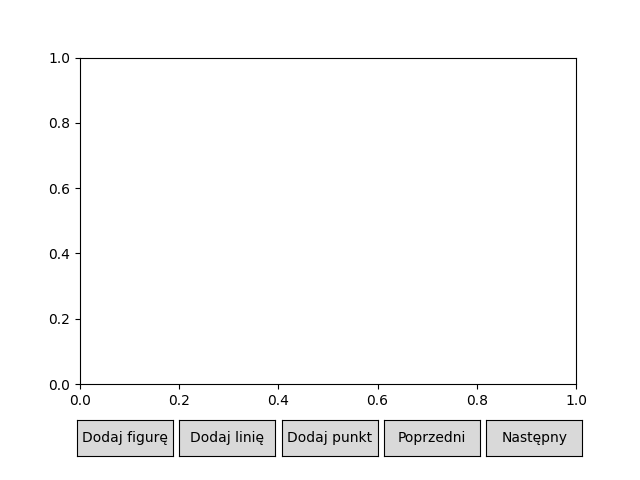

In [70]:
plot1 = Plot(xlim=[0,10], ylim=[0,10])
plot1.draw()

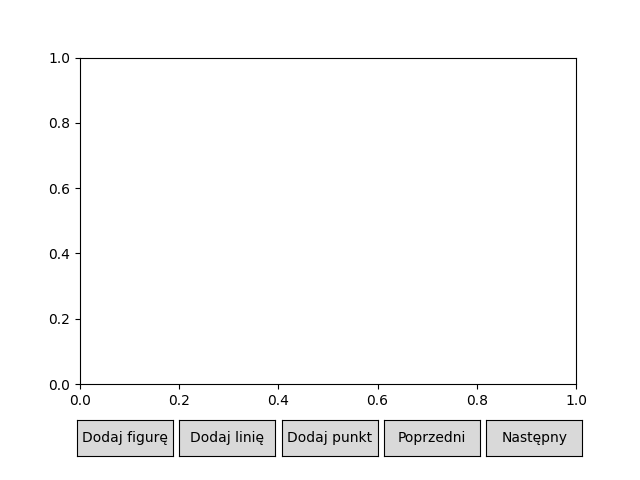

In [61]:
plot2 = Plot(xlim=[0,10], ylim=[0,10])
plot2.draw()

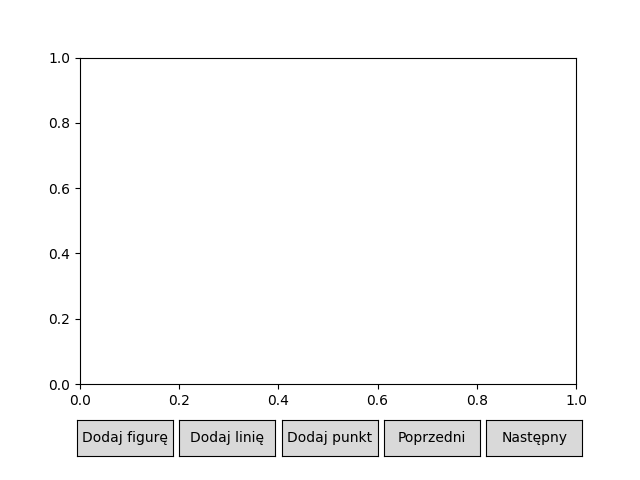

In [62]:
plot3 = Plot(xlim=[0,10], ylim=[0,10])
plot3.draw()

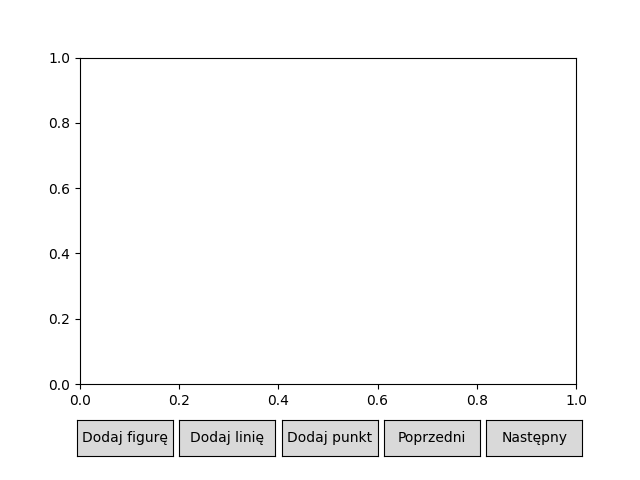

In [63]:
plot4 = Plot(xlim=[0,10], ylim=[0,10])
plot4.draw()

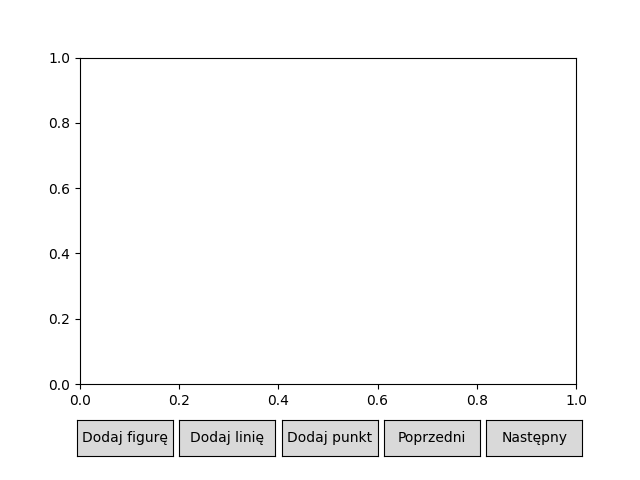

In [64]:
plot5 = Plot(xlim=[0,10], ylim=[0,10])
plot5.draw()

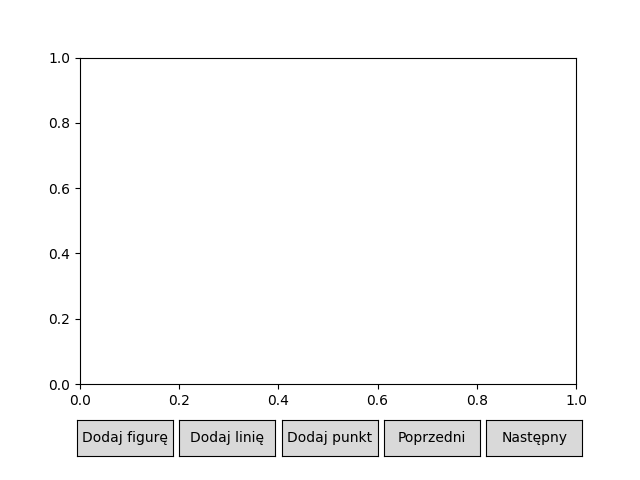

In [65]:
plot6 = Plot(xlim=[0,10], ylim=[0,10])
plot6.draw()

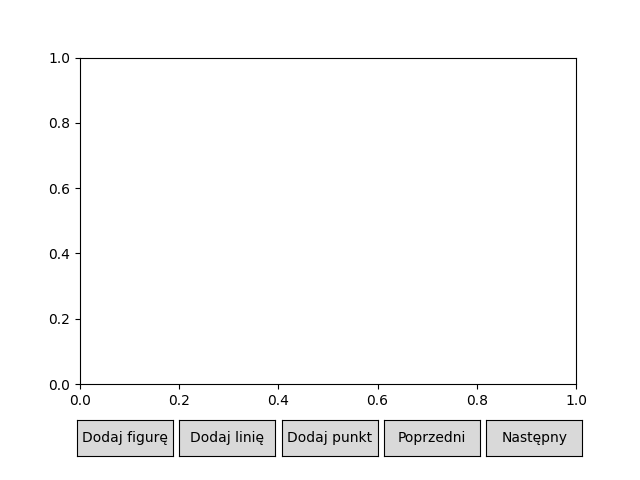

In [66]:
plot7 = Plot(xlim=[0,10], ylim=[0,10])
plot7.draw()

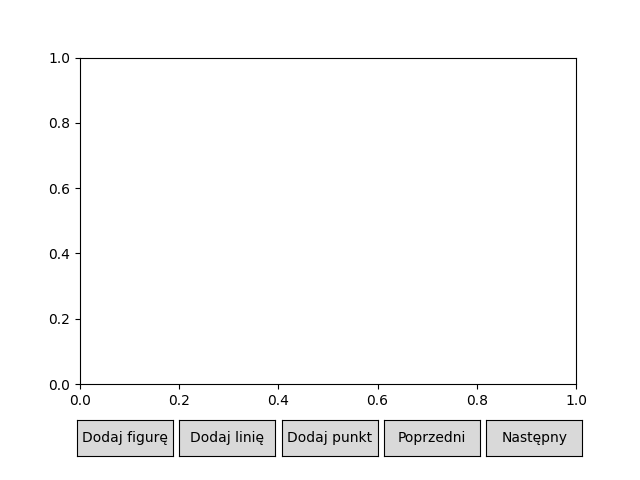

In [67]:
plot8 = Plot(xlim=[0,10], ylim=[0,10])
plot8.draw()

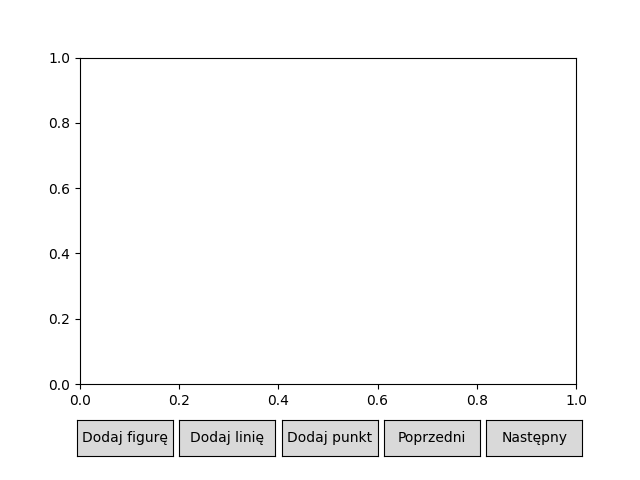

In [68]:
plot9 = Plot(xlim=[0,10], ylim=[0,10])
plot9.draw()

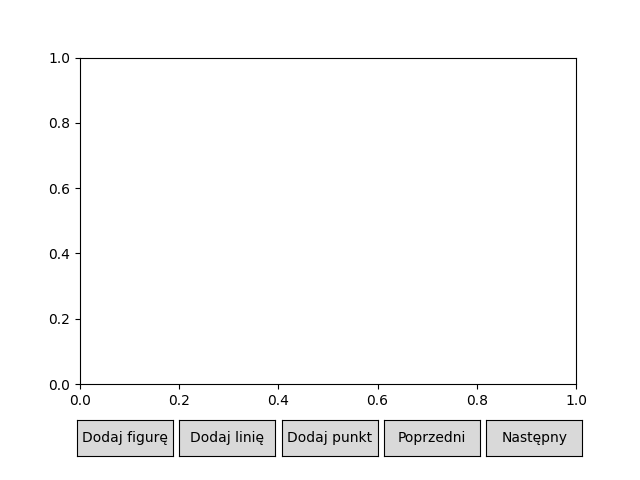

In [69]:
plot10 = Plot(xlim=[0,10], ylim=[0,10])
plot10.draw()

### Czy jest wielokąt jest monotoniczny ?

In [71]:
lines1 = linesOfPolygon(plot1)
print(monotonePolygon(lines1))

True


In [ ]:
lines2 = linesOfPolygon(plot2)
print(monotonePolygon(lines2))

In [ ]:
lines3 = linesOfPolygon(plot3)
print(monotonePolygon(lines3))

In [ ]:
lines4 = linesOfPolygon(plot4)
print(monotonePolygon(lines4))

In [ ]:
lines5 = linesOfPolygon(plot5)
print(monotonePolygon(lines5))

In [ ]:
lines6 = linesOfPolygon(plot6)
print(monotonePolygon(lines6))

In [ ]:
lines7 = linesOfPolygon(plot7)
print(monotonePolygon(lines7))

In [ ]:
lines8 = linesOfPolygon(plot8)
print(monotonePolygon(lines8))

In [ ]:
lines9 = linesOfPolygon(plot9)
print(monotonePolygon(lines9))

In [ ]:
lines10 = linesOfPolygon(plot10)
print(monotonePolygon(lines10))